### Contact on balls outside strike zone

$$\text{inv_path} = \left(1-\frac{\text{path}}{\text{batter_multiplier}}\right) \times (1+0.2 \times \text{batter_vibes})$$

$$\text{ballpark_sum} = \frac{(\text{fort} - 0.5) + 3 \times (\text{visc} - 0.5) - 6 \times (\text{fwd} - 0.5)}{10}$$

$$\text{threshold}_{\text{s12s13}} = 0.35 - 0.1 \times \text{ruth} + 0.4 \times \text{inv_path} ^ {1.5} + 0.14 \times \text{ballpark_sum}$$

$$\text{threshold}_{\text{s14s15}} = 0.4 - 0.1 \times \text{ruth} + 0.35 \times \text{inv_path} ^ {1.5} + 0.14 \times \text{ballpark_sum}$$


$\text{ruth}$ is standard pitcher ruthlessness with 20% vibes and multiplier.

In [124]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
all_files = glob.glob("../roll_data/*-contact.csv")

df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string", "is_strike": "boolean"}) for f in all_files), ignore_index=True)

seasons = [11, 12, 13, 14]
df = df[df['season'].isin(seasons)]
len(df)

/var/folders/g5/scl2096539l75kwsbhhq4pth0000gn/T/ipykernel_1067/1401709112.py:9: DtypeWarning: Columns (107,123) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string", "is_strike": "boolean"}) for f in all_files), ignore_index=True)
/var/folders/g5/scl2096539l75kwsbhhq4pth0000gn/T/ipykernel_1067/1401709112.py:9: DtypeWarning: Columns (107,123) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string", "is_strike": "boolean"}) for f in all_files), ignore_index=True)
/var/folders/g5/scl2096539l75kwsbhhq4pth0000gn/T/ipykernel_1067/1401709112.py:9: DtypeWarning: Columns (107) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string", "is_strike": "boolean"}) for f in all_files), ignore_index=True)
/var/folders/g5/scl2096539l75kwsbhhq4pth0000gn/T/ipykern

411000

In [125]:
df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

In [126]:
dfc = df.copy()
dfc = dfc[dfc["is_strike"] == False]

dfc = dfc[~((dfc["season"] == 11) & (dfc["day"] == 98))] # bad data here

# for exclude_mod in ["GROWTH", "TRAVELING", "SHELLED", "CHUNKY", "SMOOTH"]:
#     dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
#     dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
#     dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
#     dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
#     dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

dfc = dfc[~(dfc["batting_team_mods"].astype(str).str.contains("O_NO") & (dfc["ball_count"] == 0))]

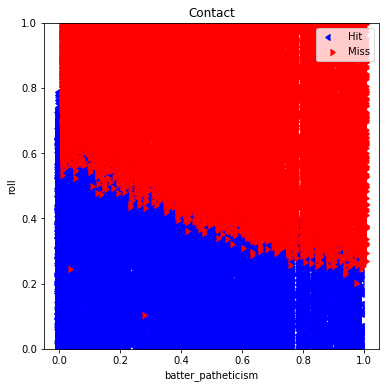

In [127]:
x_val = "batter_patheticism"
y_val = "roll"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Hit",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="Miss",
    marker=CARETRIGHTBASE,
)

ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Contact")
ax.set_ylim(0, 1)

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

In [128]:
dfc["inv_path"] = (1 - (dfc["batter_patheticism"] / dfc["batter_multiplier"])) * (1 + 0.2*dfc["batter_vibes"])
dfc.loc[dfc["inv_path"]< 0, "inv_path"] = 0
dfc["inv_path_pow"] = (dfc["inv_path"] ** 1.5)
dfc["ruth"] = dfc["pitcher_ruthlessness"] * (1 + 0.2*dfc["pitcher_vibes"]) * dfc["pitcher_multiplier"]

dfc["grand_center"] = dfc["ballpark_grandiosity"] - 0.5
dfc["fort_center"] = dfc["ballpark_fortification"] - 0.5
dfc["obt_center"] = dfc["ballpark_obtuseness"] - 0.5
dfc["om_center"] = dfc["ballpark_ominousness"] - 0.5
dfc["inc_center"] = dfc["ballpark_inconvenience"] - 0.5
dfc["visc_center"] = dfc["ballpark_viscosity"] - 0.5
dfc["fwd_center"] = dfc["ballpark_forwardness"] - 0.5
dfc["myst_center"] = dfc["ballpark_mysticism"] - 0.5
dfc["elong_center"] = dfc["ballpark_elongation"] - 0.5

dfc.loc[dfc["season"] == 11,"inv_path_pow_season"] = dfc["inv_path_pow"] * 0.4
dfc.loc[dfc["season"] == 12,"inv_path_pow_season"] = dfc["inv_path_pow"] * 0.4
dfc.loc[dfc["season"] == 13,"inv_path_pow_season"] = dfc["inv_path_pow"] * 0.35
dfc.loc[dfc["season"] == 14,"inv_path_pow_season"] = dfc["inv_path_pow"] * 0.35

dfc["ballpark_sum"] = (dfc["fort_center"] + 3*dfc["visc_center"] - 6*dfc["fwd_center"]) / 10

# we know the intercept is 0.4 in s12/s13 and 0.35 in s14/s15 so special case it here so the fit works across
dfc.loc[dfc["season"] == 13,"roll"] -= 0.05
dfc.loc[dfc["season"] == 14,"roll"] -= 0.05

In [137]:
dfc.loc[dfc["inv_path"] == 0, [
        "passed",
        "offset",
        "roll",
        "threshold",
        "inv_path_pow_season",
        "ruth",

        "ballpark_sum",
        # "event_type",
        # "weather",
        # "batter_laserlikeness",
        # "pitcher_multiplier",
        "batter_multiplier",
        "batter_name",
        # "pitcher_name",
        "batter_mods",
        # "pitcher_mods",
        "batting_team_mods",
        # "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        # "fielder_roll",
    ]]

,passed,offset,roll,threshold,inv_path_pow_season,ruth,ballpark_sum,batter_multiplier,batter_name,batter_mods,batting_team_mods,season,day,game_id,play_count
356904,True,-0.149579,0.110704,0.260283,0.0,0.872369,-0.017714,0.840404,Moses Mason,RECEIVER;UNDERPERFORMING;ALTERNATE;CHUNKY;SCAT...,GROWTH,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,112
357300,True,-0.028993,0.231290,0.260283,0.0,0.872369,-0.017714,0.840404,Moses Mason,RECEIVER;UNDERPERFORMING;SMOOTH,GROWTH,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,212
357598,False,0.076900,0.337183,0.260283,0.0,0.872369,-0.017714,0.840404,Moses Mason,RECEIVER;UNDERPERFORMING;FIRE_EATER,GROWTH,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,326
357599,False,0.624241,0.884524,0.260283,0.0,0.872369,-0.017714,0.840404,Moses Mason,RECEIVER;UNDERPERFORMING;FIRE_EATER,GROWTH,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,327
357706,False,0.233233,0.493516,0.260283,0.0,0.872369,-0.017714,0.840404,Moses Mason,RECEIVER;UNDERPERFORMING;FIRE_EATER,GROWTH,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,415
357708,True,-0.209647,0.050636,0.260283,0.0,0.872369,-0.017714,0.840404,Moses Mason,RECEIVER;UNDERPERFORMING;FIRE_EATER,GROWTH,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,416


In [131]:
X = dfc[
    [
        "roll",
        "season",
        "passed",
        "inv_path_pow_season",
        "ruth",

        "ballpark_sum",
    ]
].copy()

X = X[~X["inv_path_pow_season"].isna()].copy()

pin_intercept = None
pin_intercept = 0.35
pins = [
    (-0.1, "ruth"),
    (1, "inv_path_pow_season"),
    (0.14, "ballpark_sum"),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

y = X["passed"]
X = X.drop(["passed", "season"], axis=1)

In [132]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model


sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=100000000, tol=1e-12, fit_intercept=pin_intercept is None).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[53163    26]
 [    0 44853]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     53189
        True       1.00      1.00      1.00     44853

    accuracy                           1.00     98042
   macro avg       1.00      1.00      1.00     98042
weighted avg       1.00      1.00      1.00     98042

0.9997348075314662


In [133]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = pin_intercept or -(intercept / coef[0, 0])[0]

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if pair[1] != "roll":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]


intercept: 0.35
(-0.1, 'ruth')
(1, 'inv_path_pow_season')
(0.14, 'ballpark_sum')


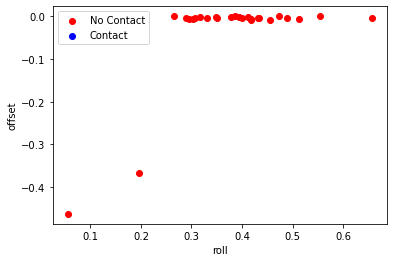

In [134]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "roll"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Contact",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Contact",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

In [135]:
pd.set_option("display.max_columns", None)
table = outliers[
    [
        "passed",
        "offset",
        # "event_type",
        # "weather",
        # "batter_laserlikeness",
        "roll",
        "threshold",
        "pitcher_multiplier",
        "batter_multiplier",
        "fielder_multiplier",
        "batter_name",
        "pitcher_name",
        "fielder_name",
        "batter_mods",
        "pitcher_mods",
        "fielder_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        # "fielder_roll",
    ]
]
print(len(table))
table.sort_values("offset", ascending=False)#[0:10]

26


,passed,offset,roll,threshold,pitcher_multiplier,batter_multiplier,fielder_multiplier,batter_name,pitcher_name,fielder_name,batter_mods,pitcher_mods,fielder_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count
327126,False,-0.000136,0.472231,0.472366,1.00,1.037879,1.037879,Lenny Spruce,Alexandria Rosales,NaN,NaN,NaN,NaN,GROWTH,NaN,13,75,56a4842f-44ab-4b71-b88c-29874b04e6d3,120
393964,False,-0.000322,0.386416,0.386738,1.00,1.031313,1.031313,Castillo Turner,Eugenia Bickle,NaN,NaN,ALTERNATE,NaN,GROWTH,BASE_INSTINCTS,11,62,4c609007-2d1e-4fbf-be1d-41996fb8e923,45
271720,False,-0.000404,0.553537,0.553941,1.00,1.050000,1.050000,Murray Pony,Shirai McElroy,NaN,INHABITING;MARKED,NaN,NaN,TRAVELING,MAINTENANCE_MODE,13,62,df302967-01f2-47ad-b2b5-fe1a12927d60,295
245575,False,-0.000504,0.265841,0.266345,1.00,1.019192,1.019192,Moses Mason,Ruslan Greatness,NaN,RECEIVER;RETURNED;DEBT_THREE,FRIEND_OF_CROWS,NaN,GROWTH,AFFINITY_FOR_CROWS,14,38,184f3dc0-ec67-4112-a93f-8c6df60df0ed,82
252848,False,-0.000921,0.411348,0.412269,1.00,1.050000,1.050000,Richardson Games,Silvia Rugrat,NaN,FLINCH;SIPHON,SIPHON,NaN,TRAVELING,NaN,14,44,50d82259-ac3f-4656-b6ac-5860384ffa30,88
306468,False,-0.001126,0.377934,0.379061,1.00,1.050000,1.050000,Alx Keming,Bright Zimmerman,NaN,NaN,NaN,NaN,TRAVELING,HIGH_PRESSURE,13,15,803368b8-7519-41ee-a278-9bfd3e3821d9,250
77228,False,-0.002359,0.348229,0.350588,1.00,1.041414,1.041414,Moses Mason,Eugenia Bickle,NaN,NaN,ALTERNATE,NaN,GROWTH,BASE_INSTINCTS,11,82,4a6f1b44-f25e-4af1-acbb-7d5e1b9cbb90,210
155557,False,-0.003022,0.393972,0.396994,1.01,1.050000,1.050000,Richardson Games,Evelton McBlase,NaN,FLINCH;SIPHON,NaN,NaN,TRAVELING;EXTRA_STRIKE,SINKING_SHIP,12,39,e2f8e6c0-00fc-49e0-bb3a-e44dcd761487,410
253933,False,-0.003030,0.316375,0.319405,1.00,1.022727,1.022727,Zesty Yaboi,Grollis Zephyr,NaN,NaN,NaN,NaN,GROWTH,POPCORN_PAYOUTS,14,45,0b1ec156-43ac-4510-ad35-5b7ebfdf7014,68
84222,False,-0.003293,0.657520,0.660813,1.00,1.050000,1.050000,Sebastian Woodman,Lenny Marijuana,NaN,FLINCH,NaN,NaN,TRAVELING;PARTY_TIME,NaN,11,89,c331efe0-fc08-4a7d-8796-4f88327bd0cc,50
